# The Big LLM Architecture Comparison - Study Guide

**Based on Sebastian Raschka's Article (2025)**

This notebook covers the architectural developments in modern Large Language Models (LLMs) from 2024-2025, focusing on structural changes rather than training techniques or benchmarks.

---

## Table of Contents

1. [Introduction & Context](#introduction)
2. [DeepSeek V3/R1](#deepseek)
   - Multi-Head Latent Attention (MLA)
   - Mixture-of-Experts (MoE)
3. [OLMo 2](#olmo)
   - Normalization Layer Placement
   - QK-Norm
4. [Gemma 3](#gemma)
   - Sliding Window Attention
   - Normalization Strategies
5. [Mistral Small 3.1](#mistral)
6. [Llama 4](#llama)
7. [Qwen3](#qwen)
8. [SmolLM3](#smollm)
   - NoPE (No Positional Embeddings)
9. [Kimi 2](#kimi)
10. [GPT-OSS](#gptoss)
11. [Grok 2.5](#grok)
12. [GLM-4.5](#glm)
13. [Qwen3-Next](#qwen-next)
14. [Key Takeaways](#takeaways)
15. [Architecture Comparison Table](#comparison)
16. [Practical Implications](#practical)
17. [Code Examples](#code)
18. [Further Reading & Resources](#resources)
19. [Study Tips](#tips)
20. [Practice Exercises](#exercises)
21. [Quick Quiz](#quiz)
22. [Revision Checklist](#checklist)
23. [Additional Resources & Next Steps](#nextsteps)

---

<a id='introduction'></a>
## 1. Introduction & Context

### Historical Perspective
It has been **7 years** since the original GPT architecture. While models from GPT-2 (2019) to DeepSeek-V3 and Llama 4 (2024-2025) appear structurally similar, several key refinements have emerged:

**Evolution of Components:**
- **Positional Embeddings**: Absolute → Rotational (RoPE)
- **Attention Mechanism**: Multi-Head Attention (MHA) → Grouped-Query Attention (GQA)
- **Activation Functions**: GELU → SwiGLU

### Why This Comparison Matters
While benchmarks vary due to different:
- Datasets
- Training techniques  
- Hyperparameters

Examining architectural choices helps us understand what LLM developers prioritize in 2025.

---

<a id='deepseek'></a>
## 2. DeepSeek V3/R1

**Release**: December 2024 (V3), January 2025 (R1)

**Key Stats:**
- Total Parameters: 671B
- Active Parameters: 37B (only 5.5% used during inference)
- Major Impact: DeepSeek R1 showed strong reasoning capabilities

### 2.1 Multi-Head Latent Attention (MLA)

#### Background: Grouped-Query Attention (GQA)
Before MLA, GQA became the standard for efficiency:

**Traditional Multi-Head Attention (MHA)**:
- Each head has its own Q, K, V projections
- High memory usage for KV cache

**Grouped-Query Attention (GQA)**:
- Multiple query heads share the same K, V projections
- Example: 4 attention heads with 2 KV groups
  - Heads 1 & 2 share one K,V pair
  - Heads 3 & 4 share another K,V pair
- **Benefits**: Lower memory, fewer parameters
- **Performance**: Comparable to MHA (per ablation studies)

#### Multi-Head Latent Attention (MLA)
**Different Strategy:**
- Instead of sharing KV heads, MLA **compresses** K and V tensors
- Compressed tensors stored in KV cache (lower dimensional space)
- At inference: compressed tensors projected back to original size
- Adds extra matrix multiplication but saves significant memory

**Why MLA over GQA?**
According to DeepSeek-V2 ablation studies:
- GQA performs worse than MHA
- **MLA performs BETTER than MHA** (slight improvement)
- This is why DeepSeek chose MLA

```
Comparison:
┌─────────────┬──────────────┬─────────────────┐
│ Method      │ Performance  │ Memory Savings  │
├─────────────┼──────────────┼─────────────────┤
│ MHA         │ Baseline     │ No savings      │
│ GQA         │ Slightly ↓   │ Good            │
│ MLA         │ Slightly ↑   │ Very Good       │
└─────────────┴──────────────┴─────────────────┘
```

### 2.2 Mixture-of-Experts (MoE)

**Core Concept:**
Replace single FeedForward block with multiple expert FeedForward blocks

**How it Works:**
1. Each transformer block has multiple expert layers (FeedForward modules)
2. Router selects only a subset of experts per token
3. Most parameters remain inactive during inference

**DeepSeek V3 Configuration:**
- 256 experts per MoE module
- Only 9 active at a time (1 shared + 8 routed)
- 671B total parameters → 37B active parameters

**Terminology:**
- **Sparse**: Only subset of parameters used (MoE)
- **Dense**: All parameters always used (traditional)

#### Shared Expert Innovation
**What**: One expert that is ALWAYS active for every token

**Why it Helps:**
- Common/repeated patterns don't need to be learned by multiple experts
- Individual experts can specialize in unique patterns
- Boosts overall performance (per DeepSpeedMoE paper)

**Key Insight:**
> MoE allows massive parameter counts (knowledge capacity) while keeping inference efficient through sparsity

---

<a id='olmo'></a>
## 3. OLMo 2

**Release**: January 2025
**Organization**: Allen Institute for AI (non-profit)

**Notable Features:**
- Full transparency (training data, code, technical reports)
- Great blueprint for developing LLMs
- At release, sat at Pareto frontier of compute-to-performance

### 3.1 Normalization Layer Placement

**Historical Context:**

1. **Original Transformer (2017) - Post-LN**:
   - Normalization AFTER attention and FeedForward
   - Outside residual connections

2. **GPT-2 and Most Modern LLMs - Pre-LN**:
   - Normalization BEFORE attention and FeedForward
   - Benefits (2020 study):
     - Better gradient behavior at initialization
     - Works without careful learning rate warm-up

3. **OLMo 2 - Modified Post-Norm**:
   - Normalization AFTER modules BUT
   - Still INSIDE residual connections (key difference!)

**Why the Change?**
- Improved training stability
- Combined with QK-Norm (see next section)

```
Architecture Flow:

Pre-Norm (GPT-2, Llama 3):          OLMo 2 Post-Norm:
Input                               Input
  ↓                                   ↓
[Norm]                              [Attention]
  ↓                                   ↓
[Attention] ──→ Add                 [Norm] ──→ Add
  ↓                                   ↓
[Norm]                              [FeedForward]
  ↓                                   ↓
[FeedForward] ──→ Add               [Norm] ──→ Add
```

### 3.2 QK-Norm

**What**: Additional RMSNorm layers inside the attention mechanism

**Where Applied:**
- To Queries (Q) before RoPE
- To Keys (K) before RoPE

**Implementation Example:**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RMSNorm(nn.Module):
    """Root Mean Square Normalization"""
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    
    def forward(self, x):
        # RMS normalization
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        x_normed = x / rms
        return self.weight * x_normed

# Simplified QK-Norm in attention
class QKNormAttention(nn.Module):
    def __init__(self, d_model, n_heads, qk_norm=True):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)
        
        self.qk_norm = qk_norm
        if qk_norm:
            self.q_norm = RMSNorm(self.head_dim)
            self.k_norm = RMSNorm(self.head_dim)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        q = self.q_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim).transpose(1, 2)
        
        # Apply QK-Norm if enabled
        if self.qk_norm:
            q = self.q_norm(q)
            k = self.k_norm(k)
        
        # Attention computation (simplified, no RoPE here)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v).transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        return self.o_proj(out)

# Example
d_model, n_heads = 512, 8
attn = QKNormAttention(d_model, n_heads, qk_norm=True)
x = torch.randn(2, 10, d_model)
output = attn(x)
print("QK-Norm applied in attention layer")
print(f"Output shape: {output.shape}")

QK-Norm applied in attention layer
Output shape: torch.Size([2, 10, 512])


**Benefits:**
- Stabilizes training loss (shown in OLMo 2 paper)
- Used by multiple models (OLMo 2, Gemma 2, Gemma 3)

**Architecture Comparison:**
```
OLMo 2 vs Llama 3:
- Both use RMSNorm, RoPE, SwiGLU
- OLMo 2: Post-Norm + QK-Norm + MHA
- Llama 3: Pre-Norm + No QK-Norm + GQA
```

---

<a id='gemma'></a>
## 4. Gemma 3

**Release**: 2025
**Developer**: Google

**Notable Aspects:**
- Large vocabulary size (supports multiple languages)
- Focus on 27B size (sweet spot: more capable than 8B, less resource-intensive than 70B)
- Also available: 1B, 4B, 12B variants
- Runs efficiently on local hardware (e.g., Mac Mini)

### 4.1 Sliding Window Attention

**Purpose**: Reduce KV cache memory requirements

**Concept:**
- **Global Attention (Regular)**: Each token can attend to ALL other tokens
- **Local Attention (Sliding Window)**: Each token attends only to a limited window of nearby tokens

**Implementation Details:**

```
Regular Attention:              Sliding Window Attention:
Token at position t             Token at position t
can attend to:                  can attend to:
All positions [0...n]           Positions [t-window...t]
                                (Local window around t)
```

**Gemma 2 vs Gemma 3 Configuration:**

| Aspect | Gemma 2 | Gemma 3 |
|--------|---------|----------|
| Global:Local Ratio | 1:1 | 1:5 |
| Sliding Window Size | 4096 tokens | 1024 tokens |
| Strategy | Every other layer | Only 1 full attention per 5 sliding |

**Memory Savings:**
- Substantial KV cache reduction shown in Gemma 3 paper
- Focus shifted more toward efficient, localized computations

**Performance Impact:**
- Ablation studies show **minimal impact** on perplexity
- Trade-off: Slightly reduced context access for much better efficiency

**Compatibility:**
- Works with both MHA and GQA
- Gemma 3 uses GQA

### 4.2 Normalization Layer Placement

**Unique Approach**: Pre-Norm AND Post-Norm simultaneously

```
Gemma 3 Architecture:

Input
  ↓
[RMSNorm] ← Pre-Norm
  ↓
[Grouped-Query Attention]
  ↓
[RMSNorm] ← Post-Norm
  ↓
Add (residual)
  ↓
[RMSNorm] ← Pre-Norm
  ↓
[FeedForward]
  ↓
[RMSNorm] ← Post-Norm
  ↓
Add (residual)
```

**Rationale:**
- Gets "best of both worlds"
- Extra normalization rarely hurts
- RMSNorm is computationally cheap
- If redundant, minimal efficiency impact

### 4.3 Gemma 3n Bonus

**Released**: Few months after Gemma 3
**Goal**: Optimized for small devices (phones)

#### Per-Layer Embedding (PLE)
**Strategy:**
- Keep only subset of parameters in GPU memory
- Stream token-specific embeddings from CPU/SSD on demand
- Significant memory savings

#### MatFormer (Matryoshka Transformer)
**Concept:**
- Single shared architecture that can be "sliced"
- Each slice is independently usable
- Run only the part you need at inference
- Like Russian nesting dolls for transformers

---

<a id='mistral'></a>
## 5. Mistral Small 3.1

**Release**: March 2025 (shortly after Gemma 3)
**Size**: 24B parameters

**Key Achievement:**
- Outperforms Gemma 3 27B on most benchmarks (except math)
- Faster inference latency

### Architecture Insights

**Efficiency Sources:**
1. Custom tokenizer
2. Reduced KV cache size
3. Fewer layers

**Notable Change:**
- Earlier Mistral models used sliding window attention
- Mistral Small 3.1 **abandoned it**
- Returned to regular GQA

**Why Drop Sliding Window?**

Speculation:
- Regular GQA allows more optimized code (FlashAttention)
- Sliding window reduces memory but may not reduce latency
- Focus shifted to inference speed over memory

```
Mistral Small 3.1 Architecture:
- Standard transformer with RMSNorm
- Grouped-Query Attention (no sliding window)
- RoPE positional embeddings
- SwiGLU activation
- Optimized for speed
```

---

<a id='llama'></a>
## 6. Llama 4

**Release**: 2024-2025
**Developer**: Meta

**Key Development**: Adopted MoE architecture (joining the trend)

### Llama 4 Maverick (400B total, 17B active)

**Architecture Comparison with DeepSeek-V3:**

| Feature | Llama 4 Maverick | DeepSeek-V3 |
|---------|------------------|-------------|
| Total Parameters | 400B | 671B |
| Active Parameters | 17B | 37B |
| Attention Type | GQA | MLA |
| Active Experts | 2 | 9 (8 + 1 shared) |
| Expert Hidden Size | 8,192 | 2,048 |
| MoE Placement | Every other block | Every block (except first 3) |

### Design Philosophy Differences

**Llama 4 Approach:**
- Fewer, larger experts
- Classic MoE setup
- Alternates MoE and dense layers

**DeepSeek V3 Approach:**
- Many small experts
- Shared expert included
- MoE in almost all layers

**Similarities:**
- Both use RMSNorm, RoPE, SwiGLU
- Both adopt MoE for efficiency
- Similar overall transformer structure

**Key Insight:**
> MoE architectures saw significant rise in popularity in 2025, with different implementation strategies

---

<a id='qwen'></a>
## 7. Qwen3

**Developer**: Qwen Team (Alibaba)
**Release**: 2025

**Notable Achievement:**
- Consistently tops leaderboards for their size classes
- Won NeurIPS 2023 LLM efficiency challenge (Qwen2)
- High-quality open-weight models

### Model Variants

**Dense Models:**
- 0.6B, 1.7B, 4B, 8B, 14B, 32B

**MoE Models:**
- 30B-A3B (30B total, 3B active)
- 235B-A22B (235B total, 22B active)

### 7.1 Qwen3 Dense (Focus on 0.6B)

**Why 0.6B is Notable:**
- Smallest current-generation open-weight model
- Excellent performance for size
- Great token/sec throughput
- Low memory footprint
- Easy to train locally (educational purposes)

**Architectural Strategy:**

```
Qwen3 0.6B:           Llama 3 1B:
- Deeper (more layers)  - Wider (more heads)
- Fewer attention heads - More attention heads
- Smaller hidden dim    - Larger hidden dim
- More transformer blocks - Fewer transformer blocks
```

**Trade-off:**
- Qwen3: Smaller memory, slower tokens/sec (more sequential operations)
- Llama 3: Larger memory, faster tokens/sec (more parallelization)

### 7.2 Qwen3 MoE

**Why Both Dense and MoE?**

**Dense Models:**
- Simpler to fine-tune
- Easier to deploy
- Better hardware compatibility
- More robust

**MoE Models:**
- Higher capacity (more knowledge)
- Lower inference cost for given capacity
- Efficient scaling

**Qwen3 235B-A22B Architecture:**
- 256 experts
- 8 active per token
- **NO shared expert** (changed from Qwen2.5-MoE)
- Uses GQA

**Why Remove Shared Expert?**

Official response from Junyang Lin (Qwen3 developer):
> "At that moment we did not find significant enough improvement on shared expert and we were worrying about the optimization for inference caused by shared expert."

**Speculation:**
- With more experts (8 vs 2), shared expert may become less necessary
- Saves compute/memory (8 experts vs 8+1)
- Training stability already achieved

---

<a id='smollm'></a>
## 8. SmolLM3

**Size**: 3B parameters
**Developer**: Hugging Face

**Key Features:**
- Sweet spot size (between 1.7B and 4B Qwen3)
- Great performance for size
- Shared training details (transparency)
- Outperforms some larger models

### 8.1 NoPE (No Positional Embeddings)

**Background: Why Positional Embeddings?**

Self-attention is **permutation invariant**:
- Treats "cat sat on mat" same as "mat on sat cat"
- Needs position information

**Traditional Solutions:**

1. **Absolute Positional Embeddings**:
   - Add learned position vectors to token embeddings
   - Example: pos_embedding[0] + token_embedding["cat"]

2. **RoPE (Rotary Position Embedding)**:
   - Rotate Q and K vectors based on position
   - Used by most modern LLMs

**NoPE Approach:**
- **No positional information added at all**
- No fixed embeddings
- No learned embeddings
- No relative encoding
- Literally nothing

**How Does It Work?**

**Key Insight**: Causal attention mask provides implicit ordering!

```
Causal Mask:
Token at position t can only see positions ≤ t

Example:
"The cat sat"
- "The" sees: [The]
- "cat" sees: [The, cat]
- "sat" sees: [The, cat, sat]

This creates implicit directional flow!
```

**Benefits of NoPE:**

1. **Better Length Generalization**:
   - Performance degrades less with longer sequences
   - Not limited by learned position embeddings

2. **Simplicity**:
   - One less component to tune
   - Fewer parameters

**SmolLM3 Implementation:**
- NoPE applied in **every 4th layer**
- Other layers still use RoPE
- Hybrid approach for safety

**Caution:**
- Original NoPE experiments: ~100M parameters
- Unclear how well it scales to larger models
- Hence the partial adoption in SmolLM3

---

<a id='kimi'></a>
## 9. Kimi 2

**Release**: 2025
**Size**: 1 Trillion parameters (1T)
**Developer**: Moonshot AI

**Major Achievement:**
- Performance on par with best proprietary models (GPT, Claude, Gemini)
- May be largest LLM of this generation
- Open-weight release

### Key Innovations

**1. Training Method:**
- First production model to use **Muon optimizer** (over AdamW)
- Previously only tested up to 16B parameters
- Smooth training loss curves

**2. Architecture:**
- Based on DeepSeek-V3 architecture
- Scaled up significantly

### Kimi K2 vs DeepSeek-V3

**Differences:**

| Component | DeepSeek-V3 | Kimi K2 |
|-----------|-------------|----------|
| Total Parameters | 671B | 1000B (1T) |
| MoE Experts | 256 | More (scaled up) |
| MLA Heads | More | Fewer |
| Layers | 61 | Scaled proportionally |

**Otherwise:**
- Same core architecture
- Multi-Head Latent Attention (MLA)
- Mixture-of-Experts with shared expert
- RMSNorm, RoPE, SwiGLU

### Historical Context

**Kimi 1.5 (January 2025):**
- Also impressive
- Released same day as DeepSeek R1
- Overshadowed by DeepSeek
- Weights never publicly shared

**Lesson Learned:**
- Kimi K2 released BEFORE DeepSeek R2
- Shared as open-weight immediately
- Gained proper recognition

**Current Status:**
As of writing, **most impressive open-weight model available**

---

<a id='gptoss'></a>
## 10. GPT-OSS

**Release**: ~One week after article published
**Developer**: OpenAI
**Significance**: First open-weight OpenAI model since GPT-2 (2019)

**Models:**
- gpt-oss-20b (20B total, 3.6B active)
- gpt-oss-120b (120B total)

### Architecture Overview

**Standard Components:**
- MoE architecture
- Grouped-Query Attention
- RMSNorm, RoPE, SwiGLU
- Similar to other 2025 models

**Unique Aspect:**
- Sliding window attention (every other layer)
- Like Gemma 3 but different ratio

### 10.1 Width vs Depth

**gpt-oss-20b vs Qwen3 30B-A3B:**

Both similar active parameters (~3.6B vs ~3.3B)

```
gpt-oss:                    Qwen3:
- Wider                     - Deeper
- 24 layers                 - 48 layers
- 2880 embedding dim        - 2048 embedding dim
- 2880 expert dim           - 768 expert dim
- More attention heads      - Fewer attention heads
```

**Trade-offs:**

**Deeper Models:**
- More flexibility
- Harder to train (gradient issues)
- Slower inference (sequential)

**Wider Models:**
- Faster inference (parallelization)
- Higher memory cost
- Better tokens/second

**Evidence:**
Gemma 2 ablation study (9B parameters):
- Wider: 52.0 average score
- Deeper: 50.8 average score
- Slight advantage to width

### 10.2 Few Large vs Many Small Experts

**gpt-oss Configuration:**
- 32 experts (surprisingly few)
- 4 active per token
- Each expert is large

**Recent Trend:**
- Move toward MORE, SMALLER experts
- Better specialization
- Improved performance

**Example Evolution:**
```
DeepSeekMoE paper showed:
16 experts → 32 experts → 64 experts
(at constant total parameter count)
= Better performance
```

gpt-oss goes against this trend (older design philosophy)

### 10.3 Attention Bias Units

**Surprising Detail:**
- Uses bias units in attention layers
- Not seen since GPT-2
- Generally considered redundant

**Research Evidence:**
Recent paper showed:
- Mathematically redundant (at least for K projection)
- Little empirical difference in performance

### 10.4 Attention Sinks

**Purpose**: Stabilize attention in long contexts

**Traditional Attention Sinks:**
- Special tokens at sequence start
- Always attended to
- Store general sequence information

**gpt-oss Implementation:**
- Not actual tokens
- Learned per-head bias logits
- Appended to attention scores
- Same goal, different method

```python
# Simplified attention sink implementation
class AttentionWithSinks:
    def __init__(self, num_heads, num_sinks=4):
        # Learned sink logits (per head)
        self.sinks = nn.Parameter(
            torch.randn(num_heads, num_sinks)
        )
    
    def forward(self, attn_scores):
        # Append sink logits to attention scores
        attn_with_sinks = torch.cat([
            self.sinks.unsqueeze(0).expand(batch, -1, -1),
            attn_scores
        ], dim=-1)
        # Continue with softmax, etc.
```

---

<a id='grok'></a>
## 11. Grok 2.5

**Release**: Weeks after article published
**Developer**: xAI (Elon Musk)
**Size**: 270B parameters

**Significance:**
- Real production model (not built for open-source)
- xAI's flagship from last year
- Rare look at actual deployed system

### Architecture Characteristics

**Overall**: Fairly standard, with notable choices

**Key Features:**

1. **Expert Configuration:**
   - 8 experts (small number)
   - Large experts
   - Reflects older MoE trend

2. **Shared Expert Design:**
   - Additional SwiGLU module (always on)
   - Functions as shared expert
   - Intermediate dimension is doubled
   - Not identical to classic shared expert but same idea

3. **Standard Components:**
   - GQA
   - RMSNorm
   - RoPE
   - SwiGLU activation

**Comparison with Modern Trends:**
```
Older Design (Grok 2.5):    Modern Design (DeepSeek V3):
- Few large experts          - Many small experts
- 8 experts                  - 256 experts
- Production-tested          - Cutting-edge research
```

**Insight:**
Shows that older MoE designs still work well in production, even if newer approaches may be theoretically better

---

<a id='glm'></a>
## 12. GLM-4.5

**Developer**: ZAI (Zhipu AI)
**Release**: 2025

**Key Achievement:**
- Instruction/reasoning hybrid
- Optimized for function calling and agents
- Outperforms Claude 4 Opus on average (12 benchmarks)
- Trails slightly behind OpenAI o3 and xAI Grok 4

### Model Variants

**1. GLM-4.5 (355B parameters)**:
- Flagship model
- Top-tier performance

**2. GLM-4.5-Air (106B parameters)**:
- Compact version
- Performance only marginally below 355B
- More efficient deployment

### Architecture Innovation

**Key Structural Choice: Dense Layers Before MoE**

Adopted from DeepSeek V3:
- **First 3 layers**: Dense (no MoE)
- **Remaining layers**: MoE

**Why Dense Layers First?**

1. **Stability During Training:**
   - MoE routing is inherently unstable early on
   - Sparse expert selection can interfere with learning

2. **Better Feature Extraction:**
   - Low-level features need stable learning
   - Syntactic and semantic basics formed first
   - Dense layers ensure solid foundation

3. **Improved Convergence:**
   - More stable gradient flow initially
   - MoE benefits appear after basics learned

```
GLM-4.5 Layer Structure:

Layers 1-3:    [Dense FeedForward] ← Stable foundation
Layers 4-n:    [MoE FeedForward]   ← Specialized processing
```

**Other Features:**
- Uses shared expert (like DeepSeek V3)
- Unlike Qwen3 which removed shared expert
- Retains attention bias (like GPT-2, gpt-oss)
- Standard: GQA, RMSNorm, RoPE, SwiGLU

**Comparison:**
```
                    GLM-4.5    Qwen3      DeepSeek-V3
Dense layers first:   ✓          ✗            ✓
Shared expert:        ✓          ✗            ✓
Attention bias:       ✓          ✗            ✗
```

---

<a id='qwen-next'></a>
## 13. Qwen3-Next

**Release**: September 2025
**Size**: 80B-A3B (80B total, 3B active)
**Developer**: Qwen Team

**Variants:**
- Instruct
- Thinking (reasoning-focused)

### Major Architectural Changes

### 13.1 Expert Configuration Evolution

**Comparison: Qwen3 235B vs Qwen3-Next 80B**

| Aspect | Qwen3 235B-A22B | Qwen3-Next 80B-A3B |
|--------|-----------------|--------------------|
| Total Size | 235B | 80B (3× smaller) |
| Active Params | 22B | 3B |
| Experts | 256 | **1024** (4× more) |
| Shared Expert | No | **Yes** (added back) |

**Key Observations:**

1. **Smaller model, MORE experts**:
   - Goes against intuition
   - Aligns with "many small experts" trend

2. **Shared expert returned**:
   - Removed in Qwen3
   - Added back in Qwen3-Next
   - Suggests benefits outweigh costs

### 13.2 Gated DeltaNet + Gated Attention Hybrid

**Purpose**: Enable 262k token context (massive increase from 32k)

**Previous Limitation:**
- Qwen3 235B: 32k native, 131k with YaRN scaling
- Standard attention: memory grows with sequence length

**New Hybrid Approach:**

**1. Gated Attention (25% of layers)**:
- Modified GQA with enhancements:
  - Output gate (sigmoid-controlled, per-channel)
  - Zero-centered RMSNorm for QK
  - Partial RoPE (subset of dimensions)
- Essentially stability improvements to GQA
- Still scaled dot-product attention

**2. Gated DeltaNet (75% of layers)**:
- **Alternative to Mamba in "linear-time" family**
- Fast-weight delta rule update
- Produces q, k, v + two gates (α, β)
- Linear and lightweight conv layers

**Ratio: 3:1 (DeltaNet : Gated Attention)**

```
Layer Pattern:
[DeltaNet] [DeltaNet] [DeltaNet] [Gated Attention]
[DeltaNet] [DeltaNet] [DeltaNet] [Gated Attention]
... (repeat)
```

**Trade-offs:**
- DeltaNet: Less precise content retrieval (linear time)
- Gated Attention: Precise but quadratic
- Hybrid: Best of both (efficiency + accuracy)

### 13.3 Multi-Token Prediction (MTP)

**Concept:**
- Traditional: Predict one token at a time
- MTP: Predict multiple future tokens simultaneously

**Implementation:**
- Extra linear heads for tokens t+1, t+2, ..., t+k (k=4 recommended)
- Sum cross-entropy losses for all offsets

**Benefits:**
1. **Training**: More signal, faster convergence
2. **Inference**: Enables speculative decoding (accept/reject multiple tokens)
3. **Qwen3-Next Specific**: Native MTP with high acceptance rate

**Quote from Qwen Blog:**
> "Qwen3-Next introduces a native Multi-Token Prediction (MTP) mechanism, which not only yields an MTP module with a high acceptance rate for Speculative Decoding but also enhances the overall performance."

**Summary:**
- Smaller, more experts, shared expert back
- DeltaNet hybrid for 262k context
- MTP for faster training/inference

---

<a id='takeaways'></a>
## 14. Key Takeaways & Trends

### Major Architectural Trends in 2025

#### 1. Rise of Mixture-of-Experts (MoE)

**Widespread Adoption:**
- DeepSeek V3/R1
- Llama 4 Maverick
- Qwen3 MoE variants
- Kimi 2
- gpt-oss
- Grok 2.5
- GLM-4.5

**Evolution Pattern:**
```
Early MoE (2024):          Modern MoE (2025):
- Few large experts        - Many small experts
- 8-32 experts            - 64-256+ experts
- Simple routing          - Shared experts
- All layers MoE          - Strategic placement
```

**Benefits:**
- Massive parameter counts without proportional inference cost
- Higher knowledge capacity
- Efficient scaling

#### 2. Attention Mechanism Evolution

**Efficiency Strategies Compared:**

| Method | Used By | Strategy | Benefits |
|--------|---------|----------|----------|
| **GQA** | Llama, Mistral, Qwen, most others | Share K,V across query heads | Standard efficiency |
| **MLA** | DeepSeek, Kimi | Compress K,V tensors | Better performance + efficiency |
| **Sliding Window** | Gemma 3 | Local attention windows | Massive KV cache savings |
| **DeltaNet Hybrid** | Qwen3-Next | Linear-time alternative | Extreme context lengths |

**Key Observation:**
- Multiple solutions to same problem
- No clear winner yet
- Different trade-offs for different use cases

#### 3. Normalization Strategies

**Convergence to RMSNorm:**
- Simpler than LayerNorm
- Fewer parameters
- Standard across all 2025 models

**Placement Variations:**

```
Model            Placement Strategy
──────────────────────────────────────────────
GPT-2/Llama 3   Pre-Norm only
OLMo 2          Post-Norm (modified)
Gemma 3         Pre-Norm + Post-Norm both
Most others     Pre-Norm (standard)
```

**QK-Norm Addition:**
- Normalization inside attention (on Q and K)
- Used by: OLMo 2, Gemma 2, Gemma 3
- Improves training stability

#### 4. Positional Encoding

**Clear Winner: RoPE**
- Rotary Position Embedding
- Used by virtually all modern models
- Replaces absolute position embeddings

**Alternative Approach:**
- SmolLM3: NoPE (No Position Embedding)
- Still experimental
- Good for length generalization
- Partial adoption (every 4th layer)

#### 5. Width vs Depth Trade-offs

**Two Design Philosophies:**

**Deeper Models (Qwen3):**
- More layers
- Smaller embedding dimension
- More sequential processing
- Pros: More flexible, smaller memory
- Cons: Slower inference, harder to train

**Wider Models (gpt-oss):**
- Fewer layers
- Larger embedding dimension
- More parallel processing
- Pros: Faster inference, better parallelization
- Cons: Higher memory usage

**Limited Evidence:**
- Gemma 2 study: Slight advantage to width
- More research needed

#### 6. Expert Configuration Evolution

**Trend: Many Small > Few Large**

```
Timeline:
2024: 8-32 large experts → Basic specialization
2025: 64-256+ small experts → Fine-grained specialization
```

**Examples:**
- DeepSeek V3: 256 experts
- Qwen3: 256 experts
- Qwen3-Next: 1024 experts (!) 
- vs older designs: 8-32 experts

**Shared Expert Status:**
- DeepSeek V3: Uses shared expert ✓
- Kimi 2: Uses shared expert ✓
- GLM-4.5: Uses shared expert ✓
- Qwen3: Removed shared expert ✗
- Qwen3-Next: Added back shared expert ✓

#### 7. Dense Layers Before MoE

**New Pattern (DeepSeek V3, GLM-4.5):**
```
Layers 1-3:    Dense FeedForward
Layers 4+:     MoE FeedForward
```

**Reasoning:**
- Stable foundation for low-level features
- Better convergence
- MoE benefits appear after basics learned

---

<a id='comparison'></a>
## 15. Architecture Comparison Table

### Quick Reference: Model Characteristics

| Model | Size | Attention | MoE | Norm Placement | Key Innovation |
|-------|------|-----------|-----|----------------|----------------|
| **DeepSeek V3** | 671B (37B active) | MLA | 256 experts | Pre-Norm | MLA + Shared expert |
| **OLMo 2** | Various | MHA | No | Post-Norm | QK-Norm + transparency |
| **Gemma 3** | 27B | GQA + Sliding | No | Pre+Post | 5:1 sliding window ratio |
| **Mistral 3.1** | 24B | GQA | No | Pre-Norm | Speed optimization |
| **Llama 4** | 400B (17B active) | GQA | Yes | Pre-Norm | MoE adoption |
| **Qwen3** | 0.6B-235B | GQA | Optional | Pre-Norm | No shared expert (MoE) |
| **SmolLM3** | 3B | GQA | No | Pre-Norm | NoPE (partial) |
| **Kimi 2** | 1T | MLA | 256+ experts | Pre-Norm | Muon optimizer |
| **gpt-oss** | 20B-120B | GQA + Sliding | Yes | Pre-Norm | Attention sinks + bias |
| **Grok 2.5** | 270B | GQA | 8 experts | Pre-Norm | Production model |
| **GLM-4.5** | 355B | GQA | Yes | Pre-Norm | Dense layers first |
| **Qwen3-Next** | 80B (3B active) | DeltaNet hybrid | 1024 experts | Pre-Norm | DeltaNet + MTP |

### Attention Strategy Distribution

```
GQA (Standard):          8 models (majority)
MLA (DeepSeek):          2 models
GQA + Sliding Window:    2 models
DeltaNet Hybrid:         1 model (newest)
Traditional MHA:         1 model (OLMo 2)
```

### MoE Adoption

```
Dense Only:              5 models (38%)
MoE:                     8 models (62%)

Trend: MoE becoming standard for large models
```

---

<a id='practical'></a>
## 16. Practical Implications

### For Researchers

**Architectural Choices Matter:**
- MLA shows performance gains over GQA
- Many small experts > few large experts
- Normalization placement affects stability
- Dense layers before MoE improves convergence

**Open Questions:**
1. Why does MLA outperform GQA?
2. Optimal expert count and size?
3. Best normalization strategy?
4. Width vs depth trade-offs?
5. When to use sliding window vs full attention?

### For Practitioners

**Model Selection Guide:**

**For Local Deployment:**
- Small models: Qwen3 0.6B-4B, SmolLM3 3B
- Medium models: Gemma 3 27B, Mistral Small 24B
- Focus: Memory footprint, tokens/sec

**For Production (Cloud):**
- MoE models: Better cost/performance
- DeepSeek V3, Llama 4, Qwen3 MoE
- Focus: Active parameters, efficiency

**For Fine-tuning:**
- Dense models easier to fine-tune
- Better hardware compatibility
- OLMo 2, Gemma 3, Qwen3 dense

**For Long Context:**
- Sliding window: Gemma 3
- DeltaNet hybrid: Qwen3-Next (262k tokens)
- MLA: DeepSeek, Kimi

**For Reasoning:**
- DeepSeek R1
- Kimi K2
- Qwen3-Next (Thinking variant)

### For Model Developers

**Recommended Stack (2025):**
```python
# Modern LLM Architecture Template

Architecture Components:
├── Positional: RoPE (standard)
├── Normalization: RMSNorm
│   ├── Placement: Pre-Norm (safe)
│   └── Optional: QK-Norm for stability
├── Activation: SwiGLU
├── Attention: GQA or MLA
│   ├── GQA: Standard choice
│   ├── MLA: Better performance, harder to implement
│   └── Optional: Sliding window for efficiency
└── FeedForward:
    ├── Dense: Layers 1-3
    └── MoE: Layers 4+
        ├── Many small experts (64-256+)
        ├── Include shared expert
        └── Smart routing
```

**Implementation Priority:**
1. Start with proven components (RoPE, RMSNorm, GQA)
2. Add MoE for large models (>10B)
3. Consider MLA for flagship models
4. Experiment with normalization for stability
5. Profile and optimize for your hardware

---

<a id='code'></a>
## 17. Code Examples

### Example 1: Basic Transformer Block (Pre-Norm)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RMSNorm(nn.Module):
    """Root Mean Square Normalization"""
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))
    
    def forward(self, x):
        # RMS normalization
        rms = torch.sqrt(torch.mean(x ** 2, dim=-1, keepdim=True) + self.eps)
        x_normed = x / rms
        return self.weight * x_normed

class MultiHeadAttention(nn.Module):
    """Standard Multi-Head Attention"""
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Project and reshape
        q = self.q_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim)
        k = self.k_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim)
        v = self.v_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim)
        
        # Transpose for attention computation
        q = q.transpose(1, 2)  # (batch, n_heads, seq_len, head_dim)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attn = F.softmax(scores, dim=-1)
        out = torch.matmul(attn, v)
        
        # Reshape and project output
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        return self.o_proj(out)

class FeedForward(nn.Module):
    """Standard FFN with SwiGLU activation"""
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.w1 = nn.Linear(d_model, d_ff, bias=False)
        self.w2 = nn.Linear(d_model, d_ff, bias=False)
        self.w3 = nn.Linear(d_ff, d_model, bias=False)
    
    def forward(self, x):
        return self.w3(F.silu(self.w1(x)) * self.w2(x))

class TransformerBlock(nn.Module):
    """Standard Pre-Norm Transformer Block (Llama-style)"""
    def __init__(self, d_model, n_heads, d_ff):
        super().__init__()
        self.norm1 = RMSNorm(d_model)
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.norm2 = RMSNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff)
    
    def forward(self, x, mask=None):
        # Pre-Norm: Normalize before attention
        x = x + self.attention(self.norm1(x), mask)
        # Pre-Norm: Normalize before FFN
        x = x + self.ffn(self.norm2(x))
        return x

# Example usage
d_model, n_heads, d_ff = 512, 8, 2048
block = TransformerBlock(d_model, n_heads, d_ff)
x = torch.randn(2, 10, d_model)  # (batch, seq_len, d_model)
output = block(x)
print("Standard Pre-Norm transformer block")
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Standard Pre-Norm transformer block
Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])


### Example 2: Grouped-Query Attention (GQA)

In [14]:
class GroupedQueryAttention(nn.Module):
    """GQA: Multiple query heads share key-value pairs"""
    def __init__(self, d_model, n_heads, n_kv_heads):
        super().__init__()
        assert n_heads % n_kv_heads == 0, "n_heads must be divisible by n_kv_heads"
        
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_kv_heads = n_kv_heads
        self.head_dim = d_model // n_heads
        self.group_size = n_heads // n_kv_heads
        
        # Query projection for all heads
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        # Key and Value projections only for KV heads
        self.k_proj = nn.Linear(d_model, n_kv_heads * self.head_dim, bias=False)
        self.v_proj = nn.Linear(d_model, n_kv_heads * self.head_dim, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)
    
    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape
        
        # Project and reshape
        q = self.q_proj(x).view(batch_size, seq_len, self.n_heads, self.head_dim)
        k = self.k_proj(x).view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        v = self.v_proj(x).view(batch_size, seq_len, self.n_kv_heads, self.head_dim)
        
        # Transpose for attention
        q = q.transpose(1, 2)  # (batch, n_heads, seq_len, head_dim)
        k = k.transpose(1, 2)  # (batch, n_kv_heads, seq_len, head_dim)
        v = v.transpose(1, 2)  # (batch, n_kv_heads, seq_len, head_dim)
        
        # Expand k, v to match number of query heads
        k = k.repeat_interleave(self.group_size, dim=1)
        v = v.repeat_interleave(self.group_size, dim=1)
        
        # Scaled dot-product attention
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attn = torch.softmax(scores, dim=-1)
        
        # Apply attention to values
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        
        return self.o_proj(out)

# Example usage
d_model, n_heads, n_kv_heads = 512, 8, 2
gqa = GroupedQueryAttention(d_model, n_heads, n_kv_heads)
x = torch.randn(2, 10, d_model)
output = gqa(x)
print(f"GQA: {n_heads} query heads share {n_kv_heads} KV pairs")
print(f"Group size: {n_heads // n_kv_heads}")
print(f"Output shape: {output.shape}")

GQA: 8 query heads share 2 KV pairs
Group size: 4
Output shape: torch.Size([2, 10, 512])


### Example 3: Sliding Window Attention Mask

In [15]:
def create_sliding_window_mask(seq_len, window_size):
    """
    Create causal sliding window attention mask
    
    Args:
        seq_len: Sequence length
        window_size: Size of sliding window
    
    Returns:
        mask: (seq_len, seq_len) boolean mask
    """
    # Start with causal mask
    mask = torch.tril(torch.ones(seq_len, seq_len))
    
    # Apply sliding window
    for i in range(seq_len):
        # Token at position i can only see [i-window_size, i]
        if i > window_size:
            mask[i, :i-window_size] = 0
    
    return mask

# Visualize
seq_len, window_size = 10, 3
mask = create_sliding_window_mask(seq_len, window_size)

print("Sliding Window Attention Mask:")
print("1 = can attend, 0 = cannot attend")
print(mask.int())
print(f"\nWindow size: {window_size}")
print(f"Each token sees at most {window_size + 1} tokens (including itself)")

Sliding Window Attention Mask:
1 = can attend, 0 = cannot attend
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 1, 1, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]], dtype=torch.int32)

Window size: 3
Each token sees at most 4 tokens (including itself)


### Example 4: SwiGLU Activation (Standard in 2025)

In [16]:
class SwiGLU(nn.Module):
    """
    SwiGLU: Swish-Gated Linear Unit
    Used in modern LLMs (DeepSeek, Llama, Qwen, etc.)
    """
    def __init__(self, d_model, d_ff):
        super().__init__()
        # Two parallel projections
        self.w1 = nn.Linear(d_model, d_ff, bias=False)  # Gate
        self.w2 = nn.Linear(d_model, d_ff, bias=False)  # Up projection
        self.w3 = nn.Linear(d_ff, d_model, bias=False)  # Down projection
    
    def forward(self, x):
        # SwiGLU(x) = (Swish(W1·x) ⊗ W2·x) · W3
        # where Swish(x) = x * sigmoid(x)
        gate = torch.nn.functional.silu(self.w1(x))  # Swish/SiLU
        x = gate * self.w2(x)  # Element-wise multiplication (gating)
        return self.w3(x)

# Example
d_model, d_ff = 512, 2048
swiglu = SwiGLU(d_model, d_ff)
x = torch.randn(2, 10, d_model)  # (batch, seq_len, d_model)
output = swiglu(x)
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print("SwiGLU replaces traditional FFN with gated activation")

Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])
SwiGLU replaces traditional FFN with gated activation


### Example 5: Simple MoE Layer

In [17]:
class SimpleMoE(nn.Module):
    """
    Simplified Mixture-of-Experts implementation
    Used in DeepSeek, Llama 4, Qwen3, etc.
    """
    def __init__(self, d_model, d_ff, num_experts, num_experts_per_token):
        super().__init__()
        self.num_experts = num_experts
        self.num_experts_per_token = num_experts_per_token
        
        # Router: decides which experts to use
        self.router = nn.Linear(d_model, num_experts, bias=False)
        
        # Expert networks (simplified as single linear layers)
        self.experts = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model, d_ff, bias=False),
                nn.SiLU(),
                nn.Linear(d_ff, d_model, bias=False)
            ) for _ in range(num_experts)
        ])
    
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        
        # Flatten for routing
        x_flat = x.view(-1, d_model)  # (batch * seq_len, d_model)
        
        # Router scores
        router_logits = self.router(x_flat)  # (batch * seq_len, num_experts)
        router_probs = torch.softmax(router_logits, dim=-1)
        
        # Select top-k experts
        top_k_probs, top_k_indices = torch.topk(
            router_probs, self.num_experts_per_token, dim=-1
        )
        # Normalize selected expert weights
        top_k_probs = top_k_probs / top_k_probs.sum(dim=-1, keepdim=True)
        
        # Apply experts
        output = torch.zeros_like(x_flat)
        for i in range(self.num_experts_per_token):
            expert_idx = top_k_indices[:, i]
            expert_weight = top_k_probs[:, i:i+1]
            
            # Apply each selected expert
            for expert_id in range(self.num_experts):
                mask = (expert_idx == expert_id)
                if mask.any():
                    expert_input = x_flat[mask]
                    expert_output = self.experts[expert_id](expert_input)
                    output[mask] += expert_weight[mask] * expert_output
        
        # Reshape back
        return output.view(batch_size, seq_len, d_model)

# Example: DeepSeek-style MoE
d_model, d_ff = 512, 2048
num_experts, active_experts = 8, 2
moe = SimpleMoE(d_model, d_ff, num_experts, active_experts)

x = torch.randn(2, 10, d_model)
output = moe(x)
print(f"MoE with {num_experts} experts, {active_experts} active per token")
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nEfficiency: Only {active_experts}/{num_experts} experts active!")

MoE with 8 experts, 2 active per token
Input shape: torch.Size([2, 10, 512])
Output shape: torch.Size([2, 10, 512])

Efficiency: Only 2/8 experts active!


### Example 6: RoPE (Rotary Position Embedding)

In [18]:
def precompute_rope_params(head_dim, seq_len, theta=10000.0):
    """
    Precompute RoPE rotation parameters
    Used by: Llama, Qwen, Mistral, and most modern LLMs
    """
    # Compute frequencies
    freq = 1.0 / (theta ** (torch.arange(0, head_dim, 2).float() / head_dim))
    
    # Create position indices
    positions = torch.arange(seq_len)
    
    # Compute angles
    angles = torch.outer(positions, freq)  # (seq_len, head_dim // 2)
    
    # Compute cos and sin
    cos = torch.cos(angles)
    sin = torch.sin(angles)
    
    return cos, sin

def apply_rope(x, cos, sin):
    """
    Apply rotary position embedding to input tensor
    
    Args:
        x: Input tensor (..., seq_len, head_dim)
        cos, sin: Precomputed rotation parameters
    """
    # Split into even and odd dimensions
    x1 = x[..., ::2]  # Even indices
    x2 = x[..., 1::2]  # Odd indices
    
    # Apply rotation
    # Reshape cos/sin to match x dimensions
    cos = cos.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, head_dim//2)
    sin = sin.unsqueeze(0).unsqueeze(0)
    
    rotated_x1 = x1 * cos - x2 * sin
    rotated_x2 = x1 * sin + x2 * cos
    
    # Interleave back
    rotated_x = torch.stack([rotated_x1, rotated_x2], dim=-1)
    rotated_x = rotated_x.flatten(-2)
    
    return rotated_x

# Example usage
head_dim, seq_len = 64, 128
cos, sin = precompute_rope_params(head_dim, seq_len)

# Simulate query/key tensor
q = torch.randn(2, 8, seq_len, head_dim)  # (batch, heads, seq_len, head_dim)
q_rotated = apply_rope(q, cos, sin)

print(f"RoPE applied to queries")
print(f"Original shape: {q.shape}")
print(f"Rotated shape: {q_rotated.shape}")
print(f"\nRoPE encodes position through rotation, no learned parameters!")

RoPE applied to queries
Original shape: torch.Size([2, 8, 128, 64])
Rotated shape: torch.Size([2, 8, 128, 64])

RoPE encodes position through rotation, no learned parameters!


### Example 7: Memory Efficiency Comparison

In [19]:
def calculate_kv_cache_size(seq_len, n_layers, n_heads, head_dim, 
                           batch_size=1, dtype_bytes=2):
    """
    Calculate KV cache memory for different attention mechanisms
    dtype_bytes: 2 for fp16/bf16, 4 for fp32
    """
    # Each position stores K and V for each layer and head
    kv_cache_bytes = (
        2 *  # K and V
        batch_size * 
        seq_len * 
        n_layers * 
        n_heads * 
        head_dim * 
        dtype_bytes
    )
    return kv_cache_bytes / (1024**3)  # Convert to GB

# Example: Compare different models
seq_len = 4096  # 4k context
n_layers = 32
head_dim = 128

print("KV Cache Memory Comparison (4k context, fp16):\n")
print(f"{'Model Type':<30} {'Heads':<10} {'Memory (GB)':<15}")
print("-" * 55)

# Multi-Head Attention (traditional)
mha_heads = 32
mha_mem = calculate_kv_cache_size(seq_len, n_layers, mha_heads, head_dim)
print(f"{'MHA (all heads)':<30} {mha_heads:<10} {mha_mem:<15.2f}")

# Grouped-Query Attention
gqa_kv_heads = 8  # 4 groups
gqa_mem = calculate_kv_cache_size(seq_len, n_layers, gqa_kv_heads, head_dim)
print(f"{'GQA (8 KV heads)':<30} {gqa_kv_heads:<10} {gqa_mem:<15.2f}")

# Multi-Head Latent Attention (compressed)
mla_compression = 0.5  # Roughly 50% compression
mla_mem = mha_mem * mla_compression
print(f"{'MLA (compressed)':<30} {'N/A':<10} {mla_mem:<15.2f}")

print("\n" + "="*55)
print(f"GQA saves: {(1 - gqa_mem/mha_mem)*100:.1f}% vs MHA")
print(f"MLA saves: {(1 - mla_mem/mha_mem)*100:.1f}% vs MHA")

# Longer context comparison
print("\n" + "="*55)
print("Impact of Long Context (32k tokens):\n")
long_seq = 32768
gqa_long = calculate_kv_cache_size(long_seq, n_layers, gqa_kv_heads, head_dim)
print(f"GQA at 32k context: {gqa_long:.2f} GB")
print(f"That's {gqa_long/gqa_mem:.1f}x more memory than 4k context!")

KV Cache Memory Comparison (4k context, fp16):

Model Type                     Heads      Memory (GB)    
-------------------------------------------------------
MHA (all heads)                32         2.00           
GQA (8 KV heads)               8          0.50           
MLA (compressed)               N/A        1.00           

GQA saves: 75.0% vs MHA
MLA saves: 50.0% vs MHA

Impact of Long Context (32k tokens):

GQA at 32k context: 4.00 GB
That's 8.0x more memory than 4k context!


### Example 8: MoE Parameter Efficiency

In [20]:
def calculate_moe_params(d_model, d_ff, n_layers, num_experts, 
                        experts_per_token, has_shared_expert=False):
    """
    Calculate total vs active parameters for MoE models
    """
    # Parameters per expert (simplified: up + down projection)
    params_per_expert = d_model * d_ff * 2
    
    # Shared expert (if present)
    shared_params = params_per_expert if has_shared_expert else 0
    
    # Total MoE parameters per layer
    total_per_layer = (params_per_expert * num_experts) + shared_params
    
    # Active parameters per token
    active_per_layer = (params_per_expert * experts_per_token) + shared_params
    
    # Total across all layers
    total_params = total_per_layer * n_layers
    active_params = active_per_layer * n_layers
    
    return total_params / 1e9, active_params / 1e9  # Return in billions

print("MoE Efficiency Comparison:\n")
print(f"{'Model':<20} {'Total (B)':<12} {'Active (B)':<12} {'Efficiency':<15}")
print("-" * 65)

# DeepSeek V3 configuration
total, active = calculate_moe_params(
    d_model=7168, d_ff=2048, n_layers=61,
    num_experts=256, experts_per_token=8,
    has_shared_expert=True
)
print(f"{'DeepSeek V3':<20} {total:<12.1f} {active:<12.1f} {(active/total)*100:<.1f}%")

# Llama 4 Maverick configuration (approximate)
total, active = calculate_moe_params(
    d_model=8192, d_ff=8192, n_layers=80,
    num_experts=16, experts_per_token=2,
    has_shared_expert=False
)
print(f"{'Llama 4 Maverick':<20} {total:<12.1f} {active:<12.1f} {(active/total)*100:<.1f}%")

# Qwen3-Next (1024 experts!)
total, active = calculate_moe_params(
    d_model=4096, d_ff=1024, n_layers=48,
    num_experts=1024, experts_per_token=8,
    has_shared_expert=True
)
print(f"{'Qwen3-Next':<20} {total:<12.1f} {active:<12.1f} {(active/total)*100:<.1f}%")

print("\n" + "="*65)
print("Key Insight: MoE models use only 5-20% of parameters during inference!")
print("This allows massive models with reasonable inference costs.")

MoE Efficiency Comparison:

Model                Total (B)    Active (B)   Efficiency     
-----------------------------------------------------------------
DeepSeek V3          460.3        16.1         3.5%
Llama 4 Maverick     171.8        21.5         12.5%
Qwen3-Next           412.7        3.6          0.9%

Key Insight: MoE models use only 5-20% of parameters during inference!
This allows massive models with reasonable inference costs.


### Example 9: Comparing Width vs Depth

In [21]:
def calculate_model_params(n_layers, d_model, n_heads, d_ff, vocab_size=50000):
    """
    Rough parameter count calculation for transformer model
    """
    head_dim = d_model // n_heads
    
    # Embedding
    embed_params = vocab_size * d_model
    
    # Per layer
    # Attention: Q, K, V, O projections
    attn_params = 4 * d_model * d_model
    # FFN: up + down
    ffn_params = 2 * d_model * d_ff
    # Layer params
    layer_params = attn_params + ffn_params
    
    total = embed_params + (n_layers * layer_params)
    return total / 1e9  # Billions

print("Width vs Depth Trade-off Analysis:\n")
print("Target: ~3B parameters\n")
print(f"{'Strategy':<15} {'Layers':<10} {'d_model':<10} {'d_ff':<10} {'Total (B)':<12}")
print("-" * 65)

# Deeper model (Qwen3-style)
deeper = calculate_model_params(
    n_layers=48, d_model=2048, n_heads=16, d_ff=5632
)
print(f"{'Deeper':<15} {48:<10} {2048:<10} {5632:<10} {deeper:<12.2f}")

# Wider model (gpt-oss-style)
wider = calculate_model_params(
    n_layers=24, d_model=2880, n_heads=24, d_ff=7680
)
print(f"{'Wider':<15} {24:<10} {2880:<10} {7680:<10} {wider:<12.2f}")

print("\n" + "="*65)
print("Trade-offs:")
print("\nDeeper (More Layers):")
print("  ✓ More flexible representations")
print("  ✓ Lower memory per layer")
print("  ✗ Slower inference (sequential)")
print("  ✗ Harder to train (gradients)")

print("\nWider (Larger d_model):")
print("  ✓ Faster inference (parallel)")
print("  ✓ Better tokens/second")
print("  ✗ Higher memory usage")
print("  ✗ Less layer-wise specialization")

Width vs Depth Trade-off Analysis:

Target: ~3B parameters

Strategy        Layers     d_model    d_ff       Total (B)   
-----------------------------------------------------------------
Deeper          48         2048       5632       2.02        
Wider           24         2880       7680       2.00        

Trade-offs:

Deeper (More Layers):
  ✓ More flexible representations
  ✓ Lower memory per layer
  ✗ Slower inference (sequential)
  ✗ Harder to train (gradients)

Wider (Larger d_model):
  ✓ Faster inference (parallel)
  ✓ Better tokens/second
  ✗ Higher memory usage
  ✗ Less layer-wise specialization


### Example 10: Visualization - Attention Pattern Comparison

Attention patterns visualized!
Saved as 'attention_patterns.png'

Memory comparison (relative):
Full attention: 210 elements (100%)
Sliding window: 105 elements (50.0%)
Sparse pattern: 90 elements (42.9%)


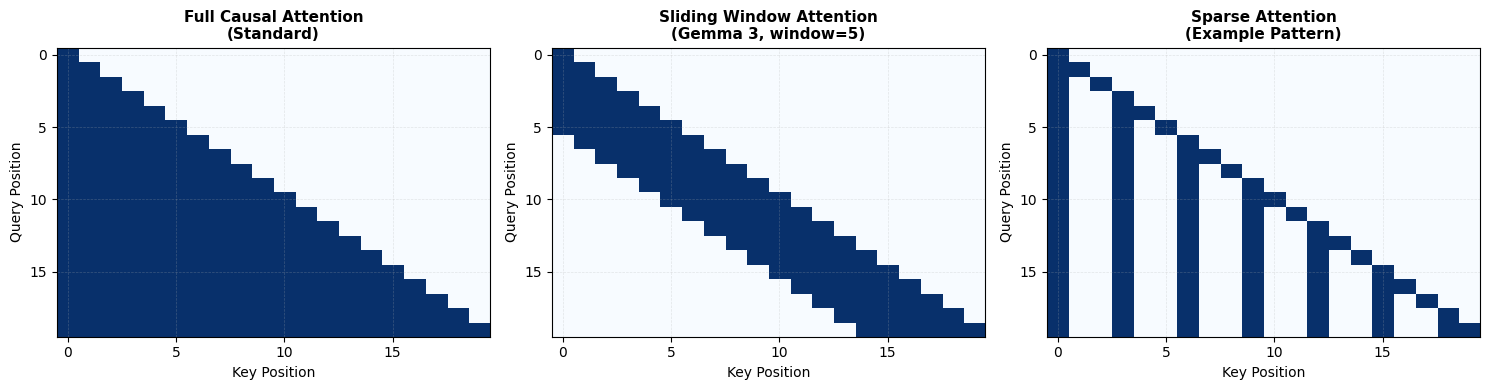

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_attention_patterns():
    """
    Visualize different attention patterns:
    - Full (causal) attention
    - Sliding window attention
    - Sparse attention
    """
    seq_len = 20
    
    # Create attention masks
    # Full causal attention
    full_mask = np.tril(np.ones((seq_len, seq_len)))
    
    # Sliding window (window=5)
    sliding_mask = np.tril(np.ones((seq_len, seq_len)))
    for i in range(seq_len):
        if i > 5:
            sliding_mask[i, :i-5] = 0
    
    # Sparse (example pattern)
    sparse_mask = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        # Can attend to itself
        sparse_mask[i, i] = 1
        # Can attend to previous positions (stride=3)
        for j in range(0, i, 3):
            sparse_mask[i, j] = 1
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    patterns = [
        (full_mask, "Full Causal Attention\n(Standard)"),
        (sliding_mask, "Sliding Window Attention\n(Gemma 3, window=5)"),
        (sparse_mask, "Sparse Attention\n(Example Pattern)")
    ]
    
    for ax, (mask, title) in zip(axes, patterns):
        im = ax.imshow(mask, cmap='Blues', aspect='auto')
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
        ax.set_xticks(range(0, seq_len, 5))
        ax.set_yticks(range(0, seq_len, 5))
        
        # Add grid
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig('attention_patterns.png', dpi=150, bbox_inches='tight')
    print("Attention patterns visualized!")
    print("Saved as 'attention_patterns.png'")
    
    # Calculate memory savings
    full_size = np.sum(full_mask)
    sliding_size = np.sum(sliding_mask)
    sparse_size = np.sum(sparse_mask)
    
    print(f"\nMemory comparison (relative):")
    print(f"Full attention: {full_size:.0f} elements (100%)")
    print(f"Sliding window: {sliding_size:.0f} elements ({sliding_size/full_size*100:.1f}%)")
    print(f"Sparse pattern: {sparse_size:.0f} elements ({sparse_size/full_size*100:.1f}%)")

# Run visualization
try:
    visualize_attention_patterns()
except ImportError:
    print("Install matplotlib to see visualizations: pip install matplotlib")

### Example 11: Model Architecture Comparison Summary

In [23]:
import pandas as pd

# Create comprehensive comparison
models_data = {
    'Model': [
        'DeepSeek V3', 'Llama 4 Maverick', 'Qwen3 Dense 32B',
        'Qwen3 MoE 235B', 'Qwen3-Next 80B', 'Gemma 3 27B',
        'Mistral Small 24B', 'SmolLM3 3B', 'Kimi K2', 'gpt-oss 20B'
    ],
    'Total_Params_B': [671, 400, 32, 235, 80, 27, 24, 3, 1000, 20],
    'Active_Params_B': [37, 17, 32, 22, 3, 27, 24, 3, 45, 3.6],
    'Attention': [
        'MLA', 'GQA', 'GQA', 'GQA', 'DeltaNet+GA', 'GQA+Sliding',
        'GQA', 'GQA', 'MLA', 'GQA+Sliding'
    ],
    'MoE': ['Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'No', 'No', 'Yes', 'Yes'],
    'Shared_Expert': ['Yes', 'No', 'N/A', 'No', 'Yes', 'N/A', 'N/A', 'N/A', 'Yes', 'No'],
    'Use_Case': [
        'General/Reasoning', 'General', 'Local/Fine-tune', 
        'Production', 'Long Context', 'Balanced',
        'Speed', 'Small/Edge', 'Flagship', 'Research'
    ]
}

df = pd.DataFrame(models_data)

# Calculate efficiency ratio
df['Efficiency_%'] = (df['Active_Params_B'] / df['Total_Params_B'] * 100).round(1)

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80 + "\n")

print(df.to_string(index=False))

print("\n" + "="*80)
print("KEY OBSERVATIONS:")
print("="*80)

print("\n1. MoE Efficiency:")
moe_models = df[df['MoE'] == 'Yes']
print(f"   Average efficiency for MoE models: {moe_models['Efficiency_%'].mean():.1f}%")
print(f"   This means only ~{moe_models['Efficiency_%'].mean():.0f}% of parameters used during inference!")

print("\n2. Attention Mechanisms:")
print(f"   GQA variants: {(df['Attention'].str.contains('GQA').sum())} models")
print(f"   MLA: {(df['Attention'] == 'MLA').sum()} models")
print(f"   Hybrid approaches: {(df['Attention'].str.contains('\+')).sum()} models")

print("\n3. Size Distribution:")
print(f"   Small (<10B): {(df['Total_Params_B'] < 10).sum()} models")
print(f"   Medium (10-100B): {((df['Total_Params_B'] >= 10) & (df['Total_Params_B'] < 100)).sum()} models")
print(f"   Large (100-500B): {((df['Total_Params_B'] >= 100) & (df['Total_Params_B'] < 500)).sum()} models")
print(f"   Massive (>500B): {(df['Total_Params_B'] >= 500).sum()} models")

print("\n" + "="*80)

<>:48: SyntaxWarning: invalid escape sequence '\+'
<>:48: SyntaxWarning: invalid escape sequence '\+'
/tmp/ipykernel_17607/1891909911.py:48: SyntaxWarning: invalid escape sequence '\+'
  print(f"   Hybrid approaches: {(df['Attention'].str.contains('\+')).sum()} models")



COMPREHENSIVE MODEL COMPARISON

            Model  Total_Params_B  Active_Params_B   Attention MoE Shared_Expert          Use_Case  Efficiency_%
      DeepSeek V3             671             37.0         MLA Yes           Yes General/Reasoning           5.5
 Llama 4 Maverick             400             17.0         GQA Yes            No           General           4.2
  Qwen3 Dense 32B              32             32.0         GQA  No           N/A   Local/Fine-tune         100.0
   Qwen3 MoE 235B             235             22.0         GQA Yes            No        Production           9.4
   Qwen3-Next 80B              80              3.0 DeltaNet+GA Yes           Yes      Long Context           3.8
      Gemma 3 27B              27             27.0 GQA+Sliding  No           N/A          Balanced         100.0
Mistral Small 24B              24             24.0         GQA  No           N/A             Speed         100.0
       SmolLM3 3B               3              3.0         GQA 

<a id='resources'></a>
## 18. Further Reading & Resources

### Original Article
- **The Big LLM Architecture Comparison** by Sebastian Raschka
- https://magazine.sebastianraschka.com/p/the-big-llm-architecture-comparison

### Key Papers Referenced

**Architecture Papers:**
1. **DeepSeek V3**: https://arxiv.org/abs/2405.04434
2. **OLMo 2**: https://arxiv.org/abs/2501.00656
3. **Gemma 3**: https://arxiv.org/abs/2503.19786
4. **Grouped-Query Attention**: Search for GQA papers
5. **NoPE (No Position Embedding)**: https://arxiv.org/abs/2305.19466
6. **DeepSeekMoE**: https://arxiv.org/abs/2401.06066

**Foundational:**
- Attention Is All You Need (Original Transformer)
- GPT-2 Paper (Pre-LN normalization)
- Llama Papers (RoPE, RMSNorm, GQA)

### Community Resources

**Model Implementations:**
- Hugging Face Transformers library
- Individual model repositories on GitHub

**Sebastian Raschka's Resources:**
- Book: *Build A Large Language Model (From Scratch)*
- Magazine: https://magazine.sebastianraschka.com/
- From-scratch implementations and guides

---

<a id='tips'></a>
## 19. Study Tips

### How to Use This Notebook

**For Quick Review:**
1. Read Key Takeaways (Section 14)
2. Check Comparison Table (Section 15)
3. Review diagrams and summaries

**For Deep Understanding:**
1. Start with Introduction (Section 1)
2. Work through each model sequentially
3. Run code examples
4. Compare similar architectures

**For Practical Application:**
1. Read Practical Implications (Section 16)
2. Study code examples (Section 17)
3. Implement components yourself

### Focus Areas by Goal

**If you're interested in:**

- **Efficiency**: Focus on MoE, GQA/MLA, Sliding Window
- **Performance**: Study DeepSeek V3, Kimi 2, MLA
- **Small models**: Deep dive into Qwen3 0.6B, SmolLM3
- **Long context**: Qwen3-Next DeltaNet, Sliding Window
- **Training stability**: OLMo 2, Gemma 3 normalization
- **Implementation**: Code examples, architectural patterns

### Key Concepts to Master

1. ✅ **Attention mechanisms**: MHA → GQA → MLA
2. ✅ **MoE fundamentals**: Sparse vs dense, routing, shared experts
3. ✅ **Normalization**: RMSNorm, Pre/Post-Norm, QK-Norm
4. ✅ **Position encoding**: RoPE vs NoPE
5. ✅ **Efficiency trade-offs**: Memory vs compute vs performance

---

<a id='exercises'></a>
## 20. Practice Exercises

Test your understanding with these exercises!

### Exercise 1: Calculate MoE Savings

**Problem**: A model has:
- 128 experts
- 4 active experts per token
- Each expert has 1B parameters
- 1 shared expert (always active)

Calculate:
1. Total parameters
2. Active parameters per token
3. Efficiency percentage

In [24]:
# Your solution here
num_experts = 128
active_experts = 4
params_per_expert = 1  # billion
has_shared_expert = True

# Calculate
total_params = num_experts * params_per_expert
active_params = active_experts * params_per_expert

if has_shared_expert:
    total_params += params_per_expert  # Add shared expert
    active_params += params_per_expert  # Shared expert always active

efficiency = (active_params / total_params) * 100

print(f"Total parameters: {total_params}B")
print(f"Active parameters: {active_params}B")
print(f"Efficiency: {efficiency:.1f}%")

# Expected: 129B total, 5B active, ~3.9% efficiency

Total parameters: 129B
Active parameters: 5B
Efficiency: 3.9%


### Exercise 2: Attention Mask Creation

**Problem**: Create a causal attention mask with a sliding window of size 4 for sequence length 8.

In [25]:
# Your solution here
def create_sliding_causal_mask(seq_len, window_size):
    mask = torch.tril(torch.ones(seq_len, seq_len))
    for i in range(seq_len):
        if i > window_size:
            mask[i, :i-window_size] = 0
    return mask

mask = create_sliding_causal_mask(8, 4)
print("Sliding Window Causal Mask (window=4):")
print(mask.int())

Sliding Window Causal Mask (window=4):
tensor([[1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0],
        [0, 0, 1, 1, 1, 1, 1, 0],
        [0, 0, 0, 1, 1, 1, 1, 1]], dtype=torch.int32)


### Exercise 3: GQA Parameter Count

**Problem**: Compare parameter counts:
- Model with MHA: 32 heads
- Model with GQA: 32 query heads, 8 KV heads
- d_model = 4096

How many parameters are saved in the attention layer?

In [26]:
# Your solution here
d_model = 4096
n_heads = 32
n_kv_heads = 8

# MHA: Q, K, V, O projections (all use d_model x d_model)
mha_params = 4 * (d_model * d_model)

# GQA: Q and O are same, but K and V are smaller
head_dim = d_model // n_heads
gqa_params = (
    d_model * d_model +  # Q projection
    d_model * (n_kv_heads * head_dim) +  # K projection (smaller)
    d_model * (n_kv_heads * head_dim) +  # V projection (smaller)
    d_model * d_model  # O projection
)

saved = mha_params - gqa_params
percentage = (saved / mha_params) * 100

print(f"MHA parameters: {mha_params/1e6:.1f}M")
print(f"GQA parameters: {gqa_params/1e6:.1f}M")
print(f"Parameters saved: {saved/1e6:.1f}M ({percentage:.1f}%)")

MHA parameters: 67.1M
GQA parameters: 41.9M
Parameters saved: 25.2M (37.5%)


<a id='quiz'></a>
## 21. Quick Quiz

### Test Your Knowledge!

**Question 1**: Which attention mechanism compresses K and V tensors into lower-dimensional space?

A) GQA  
B) MLA  
C) Sliding Window  
D) DeltaNet  

<details>
<summary>Click for answer</summary>
<b>Answer: B) MLA (Multi-Head Latent Attention)</b><br>
Used by DeepSeek V3 and Kimi K2. It compresses K,V before storing in KV cache, then projects back during inference.
</details>

---

**Question 2**: What is the main benefit of having a shared expert in MoE?

A) Reduces total parameters  
B) Speeds up training  
C) Learns common patterns once  
D) Improves routing decisions  

<details>
<summary>Click for answer</summary>
<b>Answer: C) Learns common patterns once</b><br>
Common/repeated patterns don't need to be learned by multiple individual experts, leaving them room for specialization.
</details>

---

**Question 3**: Which model uses NO positional embeddings (NoPE) in some layers?

A) Llama 4  
B) SmolLM3  
C) Gemma 3  
D) DeepSeek V3  

<details>
<summary>Click for answer</summary>
<b>Answer: B) SmolLM3</b><br>
Uses NoPE in every 4th layer. Relies on causal attention mask for implicit positional information.
</details>

---

**Question 4**: What is the ratio of sliding window to full attention layers in Gemma 3?

A) 1:1  
B) 2:1  
C) 5:1  
D) 10:1  

<details>
<summary>Click for answer</summary>
<b>Answer: C) 5:1</b><br>
Gemma 3 uses 5 sliding window layers for every 1 full attention layer. This is more aggressive than Gemma 2's 1:1 ratio.
</details>

---

**Question 5**: Which normalization placement does OLMo 2 use?

A) Pre-Norm only  
B) Post-Norm only  
C) Modified Post-Norm (inside residual)  
D) Pre-Norm and Post-Norm both  

<details>
<summary>Click for answer</summary>
<b>Answer: C) Modified Post-Norm (inside residual)</b><br>
Normalization is placed AFTER attention/FFN but still INSIDE the residual connections, unlike traditional Post-Norm.
</details>

---

**Question 6**: Qwen3-Next uses a hybrid of which two mechanisms?

A) MHA and GQA  
B) GQA and MLA  
C) DeltaNet and Gated Attention  
D) Sliding Window and Full Attention  

<details>
<summary>Click for answer</summary>
<b>Answer: C) DeltaNet and Gated Attention</b><br>
Uses 75% DeltaNet layers (linear-time) and 25% Gated Attention layers (for precision) in a 3:1 ratio.
</details>

---

**Question 7**: How many experts does Qwen3-Next have?

A) 64  
B) 256  
C) 512  
D) 1024  

<details>
<summary>Click for answer</summary>
<b>Answer: D) 1024</b><br>
Qwen3-Next has an impressive 1024 experts! This is 4x more than the original Qwen3 235B model.
</details>

---

**Question 8**: Which activation function is standard across all 2025 models?

A) ReLU  
B) GELU  
C) SwiGLU  
D) Tanh  

<details>
<summary>Click for answer</summary>
<b>Answer: C) SwiGLU</b><br>
SwiGLU (Swish-Gated Linear Unit) has replaced GELU and ReLU in modern LLMs. Used by all models in this comparison.
</details>

---

**Question 9**: Why does GLM-4.5 use dense layers before MoE layers?

A) To reduce total parameters  
B) For better training stability  
C) To speed up inference  
D) To save memory  

<details>
<summary>Click for answer</summary>
<b>Answer: B) For better training stability</b><br>
First 3 layers are dense to establish stable low-level features before MoE routing begins. Improves convergence.
</details>

---

**Question 10**: DeepSeek V3 has 671B total parameters. How many are active during inference?

A) 17B  
B) 37B  
C) 67B  
D) 134B  

<details>
<summary>Click for answer</summary>
<b>Answer: B) 37B</b><br>
Only 37B parameters active (5.5% of total). Uses 8 routed experts + 1 shared expert out of 256 total experts.
</details>

<a id='checklist'></a>
## 22. Revision Checklist

### Core Concepts to Master

Use this checklist to track your understanding:

**Attention Mechanisms:**
- [ ] Understand Multi-Head Attention (MHA) basics
- [ ] Explain Grouped-Query Attention (GQA) and how it differs from MHA
- [ ] Describe Multi-Head Latent Attention (MLA) compression strategy
- [ ] Understand sliding window attention and its memory benefits
- [ ] Know when to use each attention type

**Mixture-of-Experts (MoE):**
- [ ] Understand sparse vs dense models
- [ ] Explain how routing works in MoE
- [ ] Describe the role of shared experts
- [ ] Calculate total vs active parameters
- [ ] Understand the trend toward many small experts

**Normalization:**
- [ ] Explain RMSNorm vs LayerNorm
- [ ] Understand Pre-Norm vs Post-Norm placement
- [ ] Describe QK-Norm and its benefits
- [ ] Know which models use which strategies

**Position Encoding:**
- [ ] Understand RoPE (Rotary Position Embedding)
- [ ] Explain NoPE (No Position Embedding) approach
- [ ] Know why RoPE is the standard choice

**Model Architectures:**
- [ ] Compare DeepSeek V3 and Llama 4 architectures
- [ ] Understand Gemma 3's sliding window strategy
- [ ] Know Qwen3-Next's DeltaNet hybrid approach
- [ ] Describe Kimi K2's scale and innovations

**Practical Understanding:**
- [ ] Calculate KV cache memory for different attention types
- [ ] Estimate MoE parameter efficiency
- [ ] Understand width vs depth trade-offs
- [ ] Choose appropriate model for different use cases

**Coding:**
- [ ] Implement basic RMSNorm
- [ ] Code GQA from scratch
- [ ] Create attention masks (causal, sliding window)
- [ ] Implement SwiGLU activation
- [ ] Build simple MoE layer

### Progress Tracking

Rate your understanding (1-5) for each major section:

- DeepSeek V3/R1: ___/5
- OLMo 2: ___/5
- Gemma 3: ___/5
- Llama 4: ___/5
- Qwen3 & Qwen3-Next: ___/5
- SmolLM3: ___/5
- Kimi K2: ___/5
- gpt-oss: ___/5
- Key Trends & Takeaways: ___/5

**Study Plan Recommendations:**
- Sections rated 1-2: Need deep review, work through examples
- Sections rated 3: Review key points and practice exercises
- Sections rated 4-5: Quick review of summaries sufficient

<a id='nextsteps'></a>
## 23. Additional Resources & Next Steps

### Recommended Study Path

**Week 1: Foundations**
- Review transformer basics
- Master attention mechanisms (MHA → GQA → MLA)
- Understand normalization strategies
- Practice: Implement basic components

**Week 2: Advanced Concepts**
- Deep dive into MoE architectures
- Study efficiency techniques
- Compare model architectures
- Practice: Calculate memory and efficiency metrics

**Week 3: Practical Application**
- Model selection for different use cases
- Implementation best practices
- Read original papers
- Practice: Build complete transformer block

**Week 4: Deep Understanding**
- Analyze trade-offs
- Understand design decisions
- Study ablation studies from papers
- Practice: Design your own architecture

### Papers to Read (Priority Order)

**Must Read:**
1. Attention Is All You Need (Original Transformer)
2. GPT-2 Paper (Pre-LN normalization)
3. DeepSeek-V3 Technical Report
4. Llama 2 Paper (GQA introduction)

**Highly Recommended:**
5. OLMo 2 Technical Report (transparency)
6. Gemma 3 Paper (sliding window attention)
7. DeepSeekMoE Paper (expert specialization)
8. NoPE Paper (position embedding alternatives)

**For Deep Dives:**
9. RoPE Paper (rotary embeddings)
10. SwiGLU Paper (activation functions)
11. Flash Attention Papers (efficient implementation)
12. Mixture-of-Experts foundational papers

### Hands-On Practice

**Beginner:**
- Implement RMSNorm and compare with LayerNorm
- Create attention masks for different patterns
- Build basic transformer block

**Intermediate:**
- Implement GQA from scratch
- Build simple MoE layer with routing
- Compare memory usage of different attention types

**Advanced:**
- Implement sliding window attention efficiently
- Build MLA (latent attention)
- Create hybrid architecture combining multiple techniques

### Community & Discussion

- **Sebastian Raschka's Newsletter**: For latest LLM developments
- **Hugging Face Forums**: Model discussions and implementations
- **ArXiv**: Latest research papers
- **GitHub**: Model implementations and code examples

### Keep Learning

The field is rapidly evolving! Key areas to watch:
- Long-context handling (beyond 1M tokens)
- More efficient MoE designs
- Alternative attention mechanisms
- Smaller, more efficient models
- Multimodal architecture integration

---

## Conclusion

The LLM architecture landscape in 2025 shows both **convergence** and **diversity**:

**Convergence:**
- RMSNorm is standard
- RoPE dominates positional encoding
- SwiGLU replaces older activations
- MoE gaining widespread adoption

**Diversity:**
- Attention: GQA vs MLA vs Sliding Window vs DeltaNet
- Expert configuration: Few large vs many small
- Normalization placement: Various strategies
- Architecture dimensions: Wide vs deep

**Key Insight:**
> The fact that leading labs haven't converged to identical architectures suggests we haven't hit a ceiling yet. There's still room for innovation and improvement.

**Looking Forward:**
- MoE will likely become standard for large models
- Attention efficiency remains active research area
- Long-context handling (DeltaNet, etc.) is emerging
- Multi-token prediction gaining traction

After all these years, LLM architecture development remains exciting!

---

*Based on Sebastian Raschka's "The Big LLM Architecture Comparison" (2025)*

*This notebook is for educational purposes and revision. For the most up-to-date information, refer to the original article and model papers.*

## Final Notes

This notebook is designed to be your comprehensive guide for understanding modern LLM architectures. Use it as:

✅ **Reference Material**: Quick lookup for architecture details  
✅ **Study Guide**: Systematic learning path through concepts  
✅ **Practice Resource**: Exercises and code examples  
✅ **Revision Tool**: Checklist and quiz for testing knowledge  

**Tips for Effective Use:**
1. Don't try to memorize everything - understand the concepts
2. Run the code examples and experiment with parameters
3. Compare similar architectures to see patterns
4. Read the original papers for deeper understanding
5. Stay updated - the field evolves rapidly!

**Remember**: The goal isn't to know every detail of every model, but to understand:
- Why certain design choices are made
- Trade-offs between different approaches
- How to select and adapt architectures for your needs

Good luck with your studies! 🚀

---

*Last Updated: Based on Sebastian Raschka's article through September 2025*

*For the latest developments, visit: https://magazine.sebastianraschka.com/*